In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib import colors as mcolors
import torch
import random
import time
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, models, transforms
from sklearn.decomposition import PCA, FastICA
import itertools

sys.path.append('../src')
import tforms
import feature_extraction.feature_extraction_utils as futils
from feature_extraction.Network_Latents_Wrapper import NetworkLatents
import classifier as clf

import novelty_ODD.novelty_detector as novel

np.random.seed(42)


In [2]:
dir_data = '/home/amandari/CodeDev/ProjIntel/data/'
dir_save = '/home/amandari/CodeDev/ProjIntel/sandbox/random_files/'


# Load dataset

In [8]:
dset_name='cifar10'
extractor_name = 'resnet50_contrastive'
# pretrained_weights='/home/amandari/CodeDev/ProjIntel/Results/cifar10/111021_171807/model_saved.pt' # for cifar10
pretrained_weights=None
dim_reduce = False
num_components = 800
include_test=True
subsample_num = -1


# cifar 
type_cif='super'

# core50
inc_type='instance'


generate_raw=False
add_tf = None
device = 4



if dset_name=='mnist':
    run_extractor=False
    # MNIST
    dset_mnist = datasets.MNIST(root=dir_data, train=True)
    X = dset_mnist.data/255.0
    Y = dset_mnist.targets.numpy()
    X = torch.flatten(X, start_dim=1).numpy().astype(float)
    num_samples = X.shape[0]
    num_labels = np.unique(Y).shape[0]

    if subsample_num>0:
        rndperm = np.random.permutation(num_samples) # num rows = num samples
        inds_keep = rndperm[:subsample_num]
        X = X[inds_keep,...]
        Y = Y[inds_keep]



elif dset_name=='cifar10':
    print('bahhhhh')
    import cifar10_dataset as dset  
    num_labels = 1
    tform_apply = tforms.cifar_train()
    task_filepaths = dset.cifar10Experiments([[i for i in range(num_labels)]], dir_data +'cifar10/', dir_save, 'debug', train=True, scenario='nc', shuffle=False)
    dataset = dset.cifar10Task(dir_data +'cifar10/', train=True, tasklist=task_filepaths[0], transform=tform_apply)
    run_extractor=True
    if subsample_num>0:
        dataset.select_random_subset(subsample_num)
    target_ind = -1
    homog_ind = -2

    if include_test:
        task_filepaths_test = dset.cifar10Experiments([[i for i in range(num_labels)]], dir_data +'cifar10/', dir_save, 'debug', train=False, scenario='nc', shuffle=False)
        dataset_test = dset.cifar10Task(dir_data +'cifar10/', train=False, tasklist=task_filepaths_test[0], transform=tform_apply)
        if subsample_num>0:
            dataset_test.select_random_subset(subsample_num)





elif dset_name=='cifar100':
    import cifar100_dataset as dset  
    num_labels = 20 # subset 
    tform_apply = tforms.cifar_train()
    if type_cif=='fine':
        task_list = [[i for i in range(num_labels)]]
        target_ind = -2
        homog_ind = -2
    else:
        target_ind = -1
        homog_ind = -2
        task_list = [[i for i in range(100)]]
        # task_list = [list(itertools.chain(*task_list))]

    task_filepaths = dset.cifar100Experiments(task_list, dir_data +'cifar100/', dir_save, 'test', train=True, scenario='nc', shuffle=False)
    dataset = dset.cifar100Task(dir_data +'cifar100/', tasklist=task_filepaths[0], transform=tform_apply)
    run_extractor=True
    if subsample_num>0:
        dataset.select_random_subset(subsample_num)


    if include_test:
        task_filepaths_test = dset.cifar100Experiments([[i for i in range(num_labels)]], dir_data +'cifar100/', dir_save, 'debug', train=False, scenario='nc', shuffle=False)
        dataset_test = dset.cifar100Task(dir_data +'cifar10/', train=False, tasklist=task_filepaths_test[0], transform=tform_apply)
        if subsample_num>0:
            dataset_test.select_random_subset(subsample_num)




elif dset_name=='svhn':
    import svhn_dataset as dset  
    num_labels = 10
    tform_apply = tforms.svhn_train()
    task_filepaths = dset.svhnExperiments([[i for i in range(num_labels)]], dir_data +'svhn/', dir_save, 'test', train=True, scenario='nc', shuffle=False)
    dataset = dset.svhnTask(dir_data +'svhn/', tasklist=task_filepaths[0], transform=tform_apply, train=True)
    run_extractor=True
    if subsample_num>0:
        dataset.select_random_subset(subsample_num)
    target_ind = -1
    homog_ind = -2

    if include_test:
        task_filepaths_test = dset.svhnExperiments([[i for i in range(num_labels)]], dir_data +'svhn/', dir_save, 'debug', train=False, scenario='nc', shuffle=False)
        dataset_test = dset.svhnTask(dir_data +'svhn/', train=False, tasklist=task_filepaths_test[0], transform=tform_apply)
        if subsample_num>0:
            dataset_test.select_random_subset(subsample_num)





elif dset_name=='core50':
    import core50_dataset as dset
    if inc_type=='class':
        num_labels = 3*5 # get first 3 classes
        target_ind = -1
        homog_ind = -2
    else:
        num_labels = 2
        target_ind = -2
        homog_ind = -2
    tform_apply = tforms.core50_train()
    task_filepaths = dset.core50Experiments([[i+1 for i in range(num_labels)]], dir_data +'core50/', dir_save, 'test', train=True, scenario='nc', shuffle=False)
    dataset = dset.core50Task(dir_data +'core50/', tasklist=task_filepaths[0], transform=tform_apply, train=True)
    run_extractor=True
    if subsample_num>0:
        dataset.select_random_subset(subsample_num)

    if include_test:
        task_filepaths_test = dset.core50Experiments([[i+1 for i in range(num_labels)]], dir_data +'core50/', dir_save, 'test_test', train=False, scenario='nc', shuffle=False)
        dataset_test = dset.core50Task(dir_data +'core50/', tasklist=task_filepaths_test[0], transform=tform_apply, train=False)
        if subsample_num>0:
            dataset_test.select_random_subset(subsample_num)

    

    


bahhhhh


In [9]:

if run_extractor:
    loader = torch.utils.data.DataLoader(dataset, batch_size=50,
                                            shuffle=True, num_workers=4)

    network = clf.Resnet(num_labels, resnet_arch=extractor_name, FC_layers=[],  
            resnet_base=-1, multihead_type='single', base_freeze=True, pretrained_weights=pretrained_weights)
    network = network.to(device)
    # run extractor 
    network_inner = NetworkLatents(network, ['base.8'], pool_factors={'base.8':-1})
    start = time.time()
    print('feat extraction begin')
    current_features = futils.extract_features(network_inner, loader, \
            target_ind=target_ind, homog_ind=homog_ind, device=device, use_raw_images=generate_raw, raw_image_transform=add_tf)
    
    
    if include_test:
        loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=50,
                                            shuffle=True, num_workers=4)
        current_features_test = futils.extract_features(network_inner, loader_test, \
            target_ind=target_ind, homog_ind=homog_ind, device=device, use_raw_images=generate_raw, raw_image_transform=add_tf)

            
    print('feat extraction done', time.time()-start)
    if generate_raw==False:
        feat_name = 'base.8'
    else:
        feat_name = 'image'
    X = current_features[0][feat_name].numpy()
    Y = current_features[-2].numpy()





    if include_test:

        X_test = current_features_test[0][feat_name].numpy()
        Y_test = current_features_test[-2].numpy()+100

        X = np.concatenate((X,X_test), axis=0)
        Y = np.concatenate((Y, Y_test))

load contrastive backbone
Will fetch activations from:
base.8, average pooled by -1
feat extraction begin
feat extraction done 9.661454677581787


In [10]:
X.shape

(6000, 2048)

# Apply dim reduction, if applicable

In [11]:
if dim_reduce:
    # Dimensionality reduction, if applicable
    data_subset_red, data_subset_labels_red = novel.reduce_dim_features(X, Y, num_components=num_components)
    # data_subset_red, data_subset_labels_red = novel.reduce_dim_features_fixed(X, Y, num_components=num_components)

    feat_cols = ['pixel'+str(i) for i in range(data_subset_red.shape[1])]
    df = pd.DataFrame(data_subset_red, columns=feat_cols)
    df['Y'] = data_subset_labels_red # add label column 
    df['label'] = df['Y'].apply(lambda i: str(i)) # add label name column 
else:
    # put data in df pandas structure  
    feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feat_cols)
    df['Y'] = Y # add label column 
    df['label'] = df['Y'].apply(lambda i: str(i)) # add label name column 



In [12]:
data_subset_red.shape

(6000, 800)

# TSNE

In [13]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 1.626s...


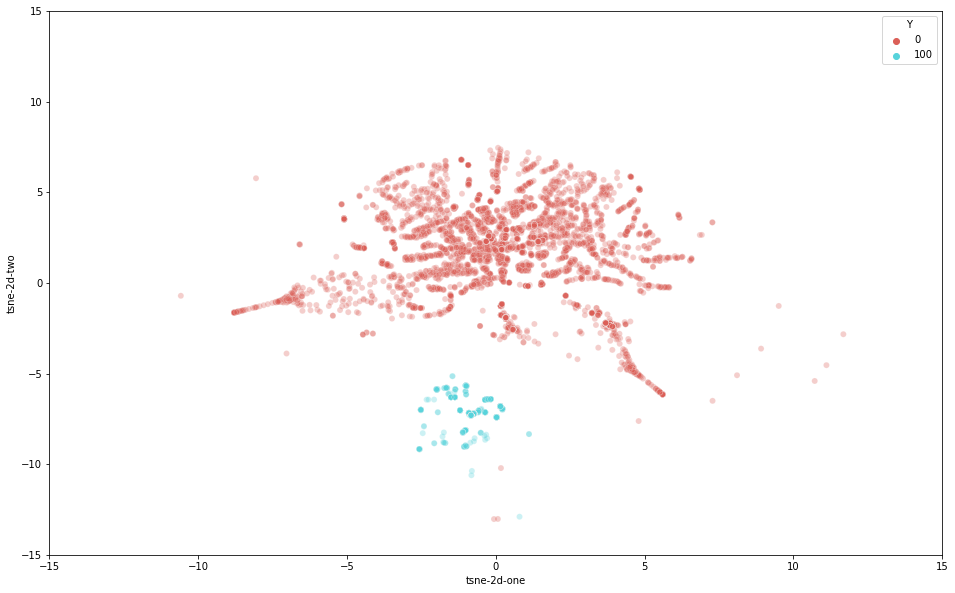

In [ ]:
%matplotlib inline
num_labels = np.unique(df['Y'].values).shape[0]
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Y",
    palette=sns.color_palette("hls", num_labels),
    data=df,
    legend="full",
    alpha=0.3
)
plt.ylim(-15, 15)
plt.xlim(-15, 15)
# plt.savefig('/home/amandari/CodeDev/ProjIntel/Results/mixed/resnet50.png')
plt.show()

In [85]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2042,pixel2043,pixel2044,pixel2045,pixel2046,pixel2047,Y,label,tsne-2d-one,tsne-2d-two
0,0.005402,0.000000,0.017733,0.010806,0.108035,0.023128,0.038925,0.026606,0.446759,0.000000,...,0.000933,0.000000,0.113622,0.000073,0.000000,0.000000,19,19,5.792937,-2.674917
1,0.000000,0.000000,0.052122,0.000688,0.222397,0.007207,0.017145,0.018731,0.043131,0.052239,...,0.000000,0.069179,0.309160,0.000000,0.000000,0.000000,4,4,4.146290,-2.048878
2,0.246361,0.000000,0.173498,0.037628,0.033421,0.117378,0.354397,0.111211,0.109686,0.163833,...,0.016534,0.304586,0.124896,0.010892,0.006242,0.000000,0,0,1.934448,-1.160951
3,0.176799,0.068356,0.118348,0.000000,0.192630,0.050379,0.206102,0.022350,0.155672,0.130995,...,0.027741,0.090263,0.115490,0.004355,0.015226,0.081649,12,12,-1.062140,-0.269756
4,0.057366,0.000023,0.431826,0.003695,0.482864,0.016897,0.089597,0.048960,0.222322,0.061571,...,0.014314,0.000000,0.116710,0.008823,0.000142,0.034094,15,15,-3.427009,1.339842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.036612,0.002618,0.221478,0.000000,0.184177,0.026178,0.122791,0.000000,0.073478,0.105709,...,0.010663,0.241415,0.122789,0.000000,0.000000,0.001041,14,14,1.266820,0.390256
19996,0.059002,0.000000,0.260945,0.021357,0.269260,0.069857,0.240874,0.108316,0.054150,0.068343,...,0.009393,0.009131,0.092669,0.012400,0.041322,0.005093,14,14,-0.406075,0.790205
19997,0.000000,0.001347,0.363796,0.000000,0.455152,0.006085,0.044036,0.021211,0.328808,0.095879,...,0.027932,0.004463,0.126591,0.000000,0.000000,0.003234,17,17,-3.237869,0.695751
19998,0.023756,0.023922,0.353004,0.043462,0.203826,0.053964,0.330039,0.020406,0.100382,0.250413,...,0.000000,0.017426,0.230466,0.002183,0.001371,0.007443,11,11,0.142897,0.678089
